In [2]:
!pip install imbalanced-learn
!pip install delayed


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Import necessary packages

In [3]:
# Packages to manipulate data
import numpy as np
import pandas as pd
from time import gmtime, strftime

In [4]:
# Packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Packages for data pre-processing
# For Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler
# For train_test_split
from sklearn.model_selection import train_test_split
# To check multi-colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
# To create balanced dataset
from imblearn.over_sampling import SMOTE

In [6]:
# Packages & dependencies for SageMaker to connect to S3 service
import boto3, re, sys, math, json, os, sagemaker

### Create S3 bucket to read & write data from

In [7]:
# Set the bucket name and region variables
bucket_name='sagemaker-bucket-brain-stroke-2'
# To check your region
my_region= boto3.session.Session().region_name
print(my_region)

us-east-1


You can access multiple services in AWS using boto3

In [8]:
# Create an s3 bucket
s3 = boto3.resource('s3')
s3.create_bucket(Bucket=bucket_name)

s3.Bucket(name='sagemaker-bucket-brain-stroke-2')

In [9]:
# Set variables to wrtite data into S3
# You are doing this step to upload data into S3
data='brain_stroke.csv'
#  prefix is the folder name inside which you want this data
prefix='pre-proessing'

In [10]:
# Write data into S3
# Step 1:  # Add file to this bucket
# Step 2: # Appled the file path- create /input folder inside pre-proessing folder
# Step 3: # Upload file
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'input/brain_stroke.csv')).upload_file("brain_stroke.csv")

### Data Cleaning

##### Read data from S3


In [11]:
# Set variables - dataset name and S3 location
data_key='brain_stroke.csv'
data_location=f's3://{bucket_name}/{prefix}/input/{data_key}'
# It is always better to parametrize variables in your code.

In [12]:
# Read data into pandas dataframe
df=pd.read_csv(data_location)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level_bmi
0,Male,NaN,0,1,Yes,Private,Urban,formerly smoked,1,1,228.69;36.6
1,Male,80.0,0,1,Yes,Private,Rural,never smoked,1,1,105.92;32.5
2,Female,NaN,0,0,Yes,Private,Urban,smokes,1,1,171.23;34.4
3,Female,79.0,1,0,Yes,Self-employed,Rural,never smoked,1,1,174.12;24
4,Male,NaN,0,0,Yes,Private,Urban,formerly smoked,1,1,186.21;29


#### Handle Missing Values                  

In [13]:
df.isnull().sum()

gender                   0
age                      5
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
smoking_status           0
stroke                   0
is_paralyzed             0
avg_glucose_level_bmi    0
dtype: int64

In [14]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [15]:
# Proportion of rows having smoking_status= unkown
df[df['smoking_status']=='Unknown'].shape[0]/df.shape[0]

0.3012794882047181

In [16]:
# Handles missing values in age by imputing with mean
df['age'].fillna(df['age'].mean(),inplace=True)

In [17]:
# Remove rows with "Unknown" smoking status
df=df[df['smoking_status']!='Unknown']

In [18]:
df.shape

(3495, 11)

##### Manage Vector Features

In [19]:
# Show the vector feature
df.avg_glucose_level_bmi.head()

0    228.69;36.6
1    105.92;32.5
2    171.23;34.4
3      174.12;24
4      186.21;29
Name: avg_glucose_level_bmi, dtype: object

In [20]:
# Apply lambda function to split the vector into 2 parts
df['avg_glucose_level']=df['avg_glucose_level_bmi'].apply(lambda x:x.split(';')[0])
df['bmi']=df['avg_glucose_level_bmi'].apply(lambda x:x.split(';')[1])

In [21]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level_bmi,avg_glucose_level,bmi
0,Male,43.412263,0,1,Yes,Private,Urban,formerly smoked,1,1,228.69;36.6,228.69,36.6
1,Male,80.000000,0,1,Yes,Private,Rural,never smoked,1,1,105.92;32.5,105.92,32.5
2,Female,43.412263,0,0,Yes,Private,Urban,smokes,1,1,171.23;34.4,171.23,34.4
3,Female,79.000000,1,0,Yes,Self-employed,Rural,never smoked,1,1,174.12;24,174.12,24
4,Male,43.412263,0,0,Yes,Private,Urban,formerly smoked,1,1,186.21;29,186.21,29


##### Manage Columns

In [22]:
df.drop('avg_glucose_level_bmi',inplace=True,axis=1)

In [23]:
df.rename(columns={'Residence_type':'residence_type'},inplace=True)

In [24]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level,bmi
0,Male,43.412263,0,1,Yes,Private,Urban,formerly smoked,1,1,228.69,36.6
1,Male,80.000000,0,1,Yes,Private,Rural,never smoked,1,1,105.92,32.5
2,Female,43.412263,0,0,Yes,Private,Urban,smokes,1,1,171.23,34.4
3,Female,79.000000,1,0,Yes,Self-employed,Rural,never smoked,1,1,174.12,24
4,Male,43.412263,0,0,Yes,Private,Urban,formerly smoked,1,1,186.21,29


##### Duplicate Rows

In [25]:
df[df.duplicated()]

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level,bmi
4990,Female,71.0,0,0,Yes,Govt_job,Rural,smokes,1,1,193.94,22.4
4991,Female,33.0,0,0,No,Private,Urban,smokes,0,0,84.4,29.7
4992,Female,53.0,0,0,No,Private,Rural,formerly smoked,0,0,235.45,32.5
4994,Male,52.0,0,1,No,Self-employed,Rural,formerly smoked,0,0,79.81,30.2
4997,Male,34.0,0,0,Yes,Private,Urban,smokes,0,0,99.23,29.7
4999,Female,45.0,0,0,Yes,Private,Urban,never smoked,0,0,202.66,31.9


In [26]:
# Drop duplicates by keeping only first rows
df.drop_duplicates(keep='first',inplace=True)

##### Parse Features to the correct datatypes

In [27]:
df.info()
#Avg_glucose_level and bmi are objects and not floating point numbers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 0 to 4989
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3489 non-null   object 
 1   age                3489 non-null   float64
 2   hypertension       3489 non-null   int64  
 3   heart_disease      3489 non-null   int64  
 4   ever_married       3489 non-null   object 
 5   work_type          3489 non-null   object 
 6   residence_type     3489 non-null   object 
 7   smoking_status     3489 non-null   object 
 8   stroke             3489 non-null   int64  
 9   is_paralyzed       3489 non-null   int64  
 10  avg_glucose_level  3489 non-null   object 
 11  bmi                3489 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 354.4+ KB


In [28]:
df['avg_glucose_level']=df['avg_glucose_level'].astype('float')
df['bmi']=df['bmi'].astype('float')
# Run above comment again to check float type

##### Format string (standardize string values)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 0 to 4989
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3489 non-null   object 
 1   age                3489 non-null   float64
 2   hypertension       3489 non-null   int64  
 3   heart_disease      3489 non-null   int64  
 4   ever_married       3489 non-null   object 
 5   work_type          3489 non-null   object 
 6   residence_type     3489 non-null   object 
 7   smoking_status     3489 non-null   object 
 8   stroke             3489 non-null   int64  
 9   is_paralyzed       3489 non-null   int64  
 10  avg_glucose_level  3489 non-null   float64
 11  bmi                3489 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 354.4+ KB


In [30]:
# Remove dahses and underscored from work_type feature
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children'], dtype=object)

In [31]:
# Use regex to replace '_' and '-' to ' '
df['work_type']=df['work_type'].str.replace(r'[-_]',' ',regex=True).astype('string')

In [32]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level,bmi
0,Male,43.412263,0,1,Yes,Private,Urban,formerly smoked,1,1,228.69,36.6
1,Male,80.000000,0,1,Yes,Private,Rural,never smoked,1,1,105.92,32.5
2,Female,43.412263,0,0,Yes,Private,Urban,smokes,1,1,171.23,34.4
3,Female,79.000000,1,0,Yes,Self employed,Rural,never smoked,1,1,174.12,24.0
4,Male,43.412263,0,0,Yes,Private,Urban,formerly smoked,1,1,186.21,29.0


In [33]:
# Convert all string features to lower case
df['gender']=df['gender'].str.lower()
df['ever_married']=df['ever_married'].str.lower()
df['work_type']=df['work_type'].str.lower()
df['residence_type']=df['residence_type'].str.lower()
df['smoking_status']=df['smoking_status'].str.lower()

In [34]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level,bmi
0,male,43.412263,0,1,yes,private,urban,formerly smoked,1,1,228.69,36.6
1,male,80.000000,0,1,yes,private,rural,never smoked,1,1,105.92,32.5
2,female,43.412263,0,0,yes,private,urban,smokes,1,1,171.23,34.4
3,female,79.000000,1,0,yes,self employed,rural,never smoked,1,1,174.12,24.0
4,male,43.412263,0,0,yes,private,urban,formerly smoked,1,1,186.21,29.0


In [52]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             string
residence_type        object
smoking_status        object
stroke                 int64
is_paralyzed           int64
avg_glucose_level    float64
bmi                  float64
dtype: object

### Data Exploration

#### Table Summary

In [35]:
df.describe()

,age,hypertension,heart_disease,stroke,is_paralyzed,avg_glucose_level,bmi
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,49.068805,0.123818,0.065921,0.059903,0.059616,108.860547,29.812611
std,18.877757,0.329421,0.248180,0.237340,0.236808,48.183574,6.225724
min,10.000000,0.000000,0.000000,0.000000,0.000000,55.120000,14.100000
25%,34.000000,0.000000,0.000000,0.000000,0.000000,77.460000,25.300000
50%,50.000000,0.000000,0.000000,0.000000,0.000000,92.590000,29.100000
75%,64.000000,0.000000,0.000000,0.000000,0.000000,116.440000,33.500000
max,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,48.900000


##### How is age distributed?

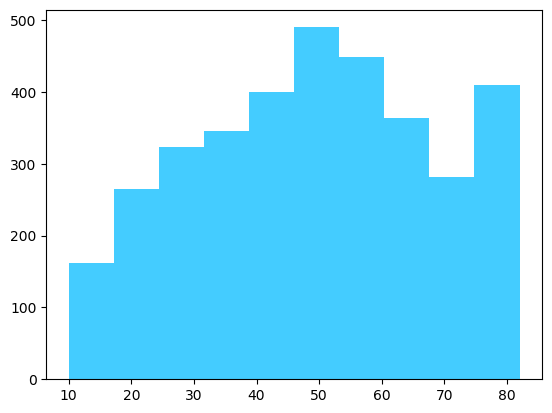

In [38]:
plt.hist(x=df['age'],color='#44ccff')
plt.show()

##### What's the relationship between age and average glucose level in a person?

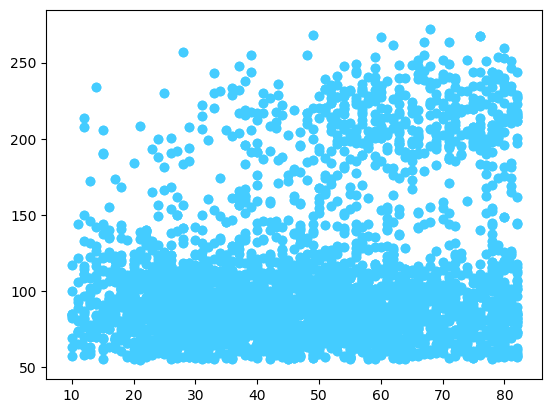

In [41]:
plt.scatter(df['age'],df['avg_glucose_level'],color='#44CCFF')
plt.show()

##### Feature Correlation

In [44]:
df.corr()

,age,hypertension,heart_disease,stroke,is_paralyzed,avg_glucose_level,bmi
age,1.000000,0.272800,0.265126,0.247423,0.232950,0.228800,0.108834
hypertension,0.272800,1.000000,0.107033,0.143458,0.133210,0.160540,0.117433
heart_disease,0.265126,0.107033,1.000000,0.137366,0.108727,0.156005,0.018592
stroke,0.247423,0.143458,0.137366,1.000000,0.920938,0.134141,0.025837
is_paralyzed,0.232950,0.133210,0.108727,0.920938,1.000000,0.130063,0.018664
avg_glucose_level,0.228800,0.160540,0.156005,0.134141,0.130063,1.000000,0.165405
bmi,0.108834,0.117433,0.018592,0.025837,0.018664,0.165405,1.000000


##### Multicollinearity Check

In [47]:
x=df.loc[:,['age','hypertension','heart_disease','avg_glucose_level','bmi']]
vif=pd.DataFrame()
vif["variables"]=x.columns
vif["VIF2"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif

,variables,VIF2
0,age,7.967873
1,hypertension,1.225353
2,heart_disease,1.156494
3,avg_glucose_level,6.399790
4,bmi,9.275085


#### Data Preparation

##### Encode Categorical

In [53]:
encd_df=df.apply(LabelEncoder().fit_transform)

In [54]:
encd_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke,is_paralyzed,avg_glucose_level,bmi
0,1,34,0,1,1,2,1,0,1,1,2821,204
1,1,71,0,1,1,2,0,1,1,1,1853,163
2,0,34,0,0,1,2,1,2,1,1,2454,182
3,0,70,1,0,1,3,0,1,1,1,2462,78
4,1,34,0,0,1,2,1,0,1,1,2502,128


##### Data Imbalance Check

In [56]:
encd_df.stroke.value_counts()

0    3280
1     209
Name: stroke, dtype: int64

In [57]:
#Data is imbalanced

In [60]:
##### Oversampling using SMOTE
oversample=SMOTE(random_state=2,sampling_strategy='minority')
X0=encd_df.loc[:,encd_df.columns!='stroke']
y0=encd_df.loc[:,'stroke']
X=X0.values
y=y0.values
x,y=oversample.fit_resample(x,y)
X=pd.DataFrame(x,columns=X0.columns)
y=pd.DataFrame(y,columns=['stroke'])
sm_df=pd.concat([x,y],axis=1)

In [63]:
sm_df.stroke.value_counts()

1    3280
0    3280
Name: stroke, dtype: int64

In [64]:
encd_df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'smoking_status', 'stroke',
       'is_paralyzed', 'avg_glucose_level', 'bmi'],
      dtype='object')

In [65]:
sm_df.to_csv('brain_stroke_processed_v2.csv',index=False)

#### Process Numeric

In [68]:
sc=StandardScaler()
sm_df[['age','avg_glucose_level','bmi']]=sc.fit_transform(sm_df[['age','avg_glucose_level','bmi']])
sm_df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,-0.785056,0,1,1.884198,1.164081,1
1,1.196021,0,1,-0.273476,0.435832,1
2,-0.785056,0,0,0.874343,0.773313,1
3,1.141875,1,0,0.925134,-1.073955,1
4,-0.785056,0,0,1.137615,-0.185845,1


#### Handle Outliers

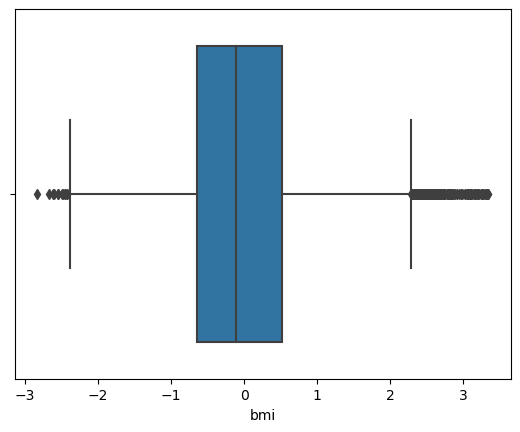

In [69]:
sns.boxplot(x=sm_df['bmi'])
plt.show()

In [70]:
upper_limit=sm_df['bmi'].mean()+(2*sm_df['bmi'].std())
lower_limit=sm_df['bmi'].mean()-(2*sm_df['bmi'].std())

In [71]:
sm_df=sm_df[(sm_df['bmi']<=upper_limit)&(sm_df['bmi']>=lower_limit)]

##### Split data

In [79]:
x=sm_df.loc[:,sm_df.columns!='stroke']
y=sm_df.loc[:,'stroke']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=123)

#### Exporting the data

In [ ]:
x_train.to_csv('x_train.csv',index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'output/split_data/x_train.csv')).upload_file('x_train.csv')

x_test.to_csv('x_test.csv',index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'output/split_data/x_test.csv')).upload_file('x_test.csv')

y_train.to_csv('y_train.csv',index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'output/split_data/y_train.csv')).upload_file('y_train.csv')

y_test.to_csv('y_test',index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'output/split_data/y_test.csv')).upload_file('y_test.csv')